We use parallel tempering to solve the max-cut problem on an Erdős–Rényi random graph G(N, p), which is equivalent to finding the ground state of the antiferromagnetic Ising model. 10 steps.

In [1]:
import os
os.chdir('../')
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.0"  # A100

import torch
import numpy as np
import networkx as nx
from math import log10, ceil
from random import randint

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
from tqdm import tqdm

from src.tempering.temperer import Temperer
from src.utils import J2Q

In [2]:
device = torch.device("cuda")
dtype = torch.float32

ured = (0.86, 0.08, 0.24)
ublue = (0.12, 0.56, 1.0)

In [3]:
"""
W: number of systems (different J matrices)
L: number of temperature levels
K: number of parallel copies per temperature
N: number of variables
"""
W, L, K, N, d, nsteps = 20, 30, 10, 4_000, 20, 10
beta = torch.logspace(-3, 1, steps=L, device=device)

In [4]:
p = d/N
am = (torch.rand((W, N, N), device=device, dtype=dtype) < p).to(dtype)
J = torch.randn((W, N, N), device=device, dtype=dtype)
J = torch.triu(am * J, diagonal=1)
J = (J + J.permute(0, 2, 1))/2

# J = torch.tensor(nx.to_numpy_array(nx.grid_2d_graph(20, 50)), device=device, dtype=dtype)

Q = torch.stack([J2Q(j.abs()) for j in J])

In [5]:
pt = Temperer(N, K, Q, beta, device=device, dtype=dtype)
# warm up
pt.step()
E = pt.exchange()

In [6]:
pt = Temperer(N, K, Q, beta, device=device, dtype=dtype)

Es = torch.zeros((nsteps, W, L, K), dtype=dtype)
for i in tqdm(range(nsteps), bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}'):
    pt.step()
    torch.cuda.synchronize()
    E = pt.exchange()
    Es[i] = E.cpu()

100%|████████████████████| 10/10 [00:14<00:00,  1.45s/it]


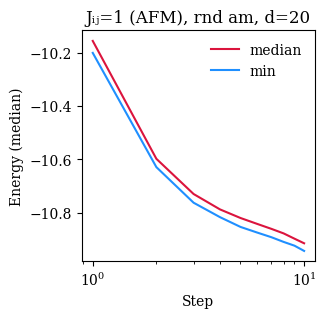

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
x = np.arange(nsteps) + 1
y1 = Es[:, :, -1, :].median(dim=2).values.mean(dim=1)/N
y2 = Es[:, :, -1, :].min(dim=2).values.mean(dim=1)/N
ax.plot(x, y1, color=ured, label='median')
ax.plot(x, y2, color=ublue, label='min')

ax.set_xlabel('Step')
ax.set_ylabel('Energy (median)')
ax.set_xscale('log')
ax.legend(frameon=False)
ax.set_title(f'Jᵢⱼ=1 (AFM), rnd am, d={d}')
plt.show()

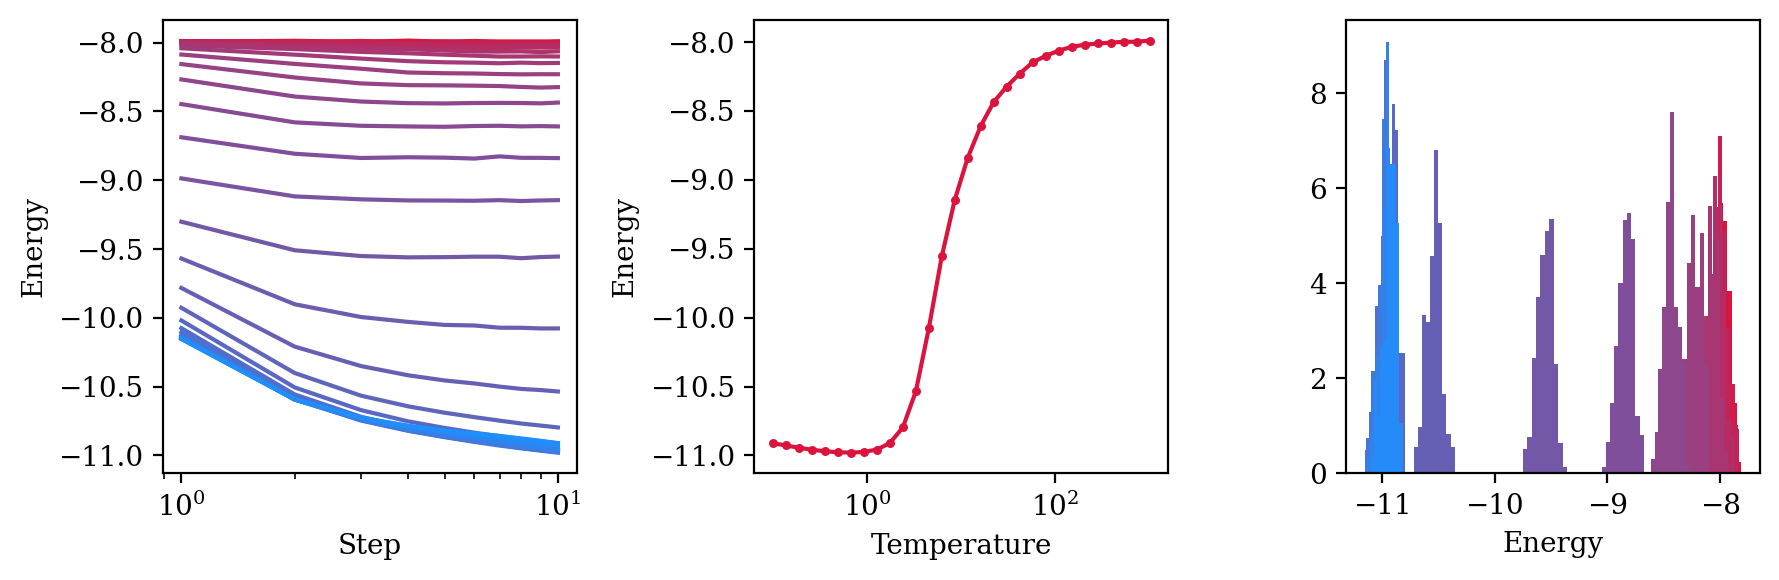

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi=200)

x = np.arange(nsteps) + 1
for i in range(L):
    c = i/(L-1)
    color = tuple(c * np.array(ublue) + (1 - c) * np.array(ured))
    y = Es[:, :, i].mean(dim=(1,-1)).cpu().numpy() / N
    ax1.plot(x, y, color=color)
ax1.set_xlabel('Step')
ax1.set_ylabel('Energy')
ax1.set_xscale('log')

x = beta
y = Es[-1, :, :].mean(dim=(0,2)) / N
x, y = x.cpu().numpy(), y.cpu().numpy()
ax2.plot(1/x, y, color=ured)
ax2.scatter(1/x, y, color=ured, s=5)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Energy')
ax2.set_xscale('log')

for i in range(0, L, 2):
    c = i/(L-1)
    color = tuple(c * np.array(ublue) + (1 - c) * np.array(ured))
    ax3.hist(Es[-1, :, i].flatten().numpy() / N, color=color, density=True)
ax3.set_xlabel('Energy')

plt.tight_layout()
plt.show()